# Roget's Thesaurus in the 21st Century

The first known thesaurus was written in the 1st century CE by [Philo of Byblos](https://en.wikipedia.org/wiki/Philo_of_Byblos); it was called *Περὶ τῶν διαφόρως σημαινομένων*, loosly translated in English as *On Synonyms*. Fast forward about two millenia and we arrive to the most well known thesaurus, compiled by [Peter Mark Roget](https://en.wikipedia.org/wiki/Peter_Mark_Roget), a British physician, natural theologian, and lexicographer. [Roget's Thesaurus](https://en.wikipedia.org/wiki/Roget%27s_Thesaurus) was released on 29 April 1852, containing 15,000 words. Subsequent editions were larger, with the latest totalling 443,000 words. In Greek the most well known thesaurus, *Αντιλεξικόν ή Ονομαστικόν της Νεοελληνικής Γλώσσης* was released in 1949 by [Θεολόγος Βοσταντζόγλου](https://el.wikipedia.org/wiki/%CE%98%CE%B5%CE%BF%CE%BB%CF%8C%CE%B3%CE%BF%CF%82_%CE%92%CE%BF%CF%83%CF%84%CE%B1%CE%BD%CF%84%CE%B6%CF%8C%CE%B3%CE%BB%CE%BF%CF%85); the latest updated edition was released in 2008 and remains an indispensable source for writing in Greek.

Roget organised the entries of the thesaurus in a hierarchy of categories. Your task in this assignment is to investigate how these categories fare with the meaning of English words as captured by Machine Learning techniques, namely, their embeddings.

> Ioannis Kalantzis <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8200235@aueb.gr

## Get Roget's Thesaurus Classification

* We found all the words and phrases from [The Project Gutenberg eBook of Roget's Thesaurus](https://www.gutenberg.org/cache/epub/22/pg22-images.html?fbclid=IwAR3lEDspv0W-xVm-5iWSxJnz16rogPpyxsUpPHtvmcNjFb3fS-zE1jghPaQ#sect16), and extracted them as described below. We used two different libraries, BeautifulSoup and requests, to get the html file contents. 

In [1]:
from bs4 import BeautifulSoup
import requests

r = requests.get("https://www.gutenberg.org/cache/epub/22/pg22-images.html?fbclid=IwAR3lEDspv0W-xVm-5iWSxJnz16rogPpyxsUpPHtvmcNjFb3fS-zE1jghPaQ#sect16")

html = r.text
soup = BeautifulSoup(html, 'html.parser')
soup 

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/><style>
#pg-header div, #pg-footer div {
    all: initial;
    display: block;
    margin-top: 1em;
    margin-bottom: 1em;
    margin-left: 2em;
}
#pg-footer div.agate {
    font-size: 90%;
    margin-top: 0;
    margin-bottom: 0;
    text-align: center;
}
#pg-footer li {
    all: initial;
    display: block;
    margin-top: 1em;
    margin-bottom: 1em;
    text-indent: -0.6em;
}
#pg-footer div.secthead {
    font-size: 110%;
    font-weight: bold;
}
#pg-footer #project-gutenberg-license {
    font-size: 110%;
    margin-top: 0;
    margin-bottom: 0;
    text-align: center;
}
#pg-header-heading {
    all: inherit;
    text-align: center;
    font-size: 120%;
    font-weight:bold;
}
#pg-footer-heading {
    all: inherit;
    text-align: center;
    font-size: 120%;
    font-weight: normal;
    margin-top: 0;
    margin-bottom: 0;
}
#pg-header #pg-machine-header p {
    text-indent: -4em;
    margin-left: 4em;
    margin-to

* As we can observe in the above HTML document, all classes are represented with an `h2` tag, as well as divisions -in cases where further categorization is followed. 
* The sections of each class or division are represented with an `h3` tag, while the words appear as text within a `p` tag, class="p2".

##### Word Extraction from p tags 
* We observe some specific patterns in the paragraphs of the text that we should consider during the process of extracting our words, by reading both the website's and the html's contents.
1. We notice that the words in our text are separated by the following characters: ',', ';', '.'. 
2. Additionally, many words are those found between [] and we don't consider them usefull for our analysis. 
3. Certainly, we should take into account that while reading the contents of a paragraph, we might encounter as a result single letters. For example some paragraphs have the -N indicating that the following words are nouns.
4. Because we will use the get_text function of the BeautifulSoup Library for extracting the words, there might be some '\n' present which we will replace with a space.

* For those reasons we created the following function, taking as input the get_text function output of the `p` tag, and returns the words or phrases.

In [2]:
def extract_words(text):
    separators = [',', ';', '.']
    words = []
    current_word = ""
    skip_next = False
    
    for char in text:
        if char == '[':
            skip_next = True
            continue
        elif char == ']':
            skip_next = False
            continue
        if char in separators:
            if current_word.strip():
                words.append(current_word.strip())
            current_word = ""
        elif char.isdigit() or skip_next:
            continue
        elif char.isalnum() or char in ["'", "-", " "]:
            current_word += char
        elif char == '\n':
            current_word += ' '
            
    if current_word.strip():
        words.append(current_word.strip())
    words = [word for word in words if len(word) > 1]
    
    return words

* Unfortunately, we won't be able to break down the following code into smaller parts, so the explanation will occur here. 

* By observing the html elements and contents, we found specific patterns followed to display the classes, divisions, sections and texts. 
1. Firstly, all `h2` tags refer to a class or division name, when containing the CLASS or DIVISION words, correspondingly.
2. We check the following tags and if the tag is a `p` tag and its class is not `p2`, we take the next tag. This if statement is helpful because, sometimes, the writers used random `p` tags, irrelavant to the words. 
3. We check for the next tag and if it is an `h3` tag, then we have a new section we, consequently, search for the `p` tags-class = "p2", till the next tag is not a `p2`. 
4. In the end of each section, we store the text, class, section and division data into a DataFrame.

* The numbers indicate the hierarchy of our checks and actions, as briefly mentioned above.

In [3]:
import pandas as pd

dfs = []
data = []
words=[]

h2_tags = soup.find_all('h2')

for h2_tag in h2_tags:
    tag_name =  h2_tag.get_text()
    
    if 'CLASS' in tag_name:
        class_name = tag_name
        division_name = 'None'
    elif 'DIVISION' in tag_name:
        division_name = tag_name
        
    next_tag = h2_tag.find_next_sibling()
    
    if next_tag and next_tag.name == 'p' and next_tag.get('class') != ['p2']:
        next_tag = next_tag.find_next_sibling()
        
    while (next_tag and next_tag.name == 'h3') :
        section_name = next_tag.get_text()
        next_tag = next_tag.find_next_sibling()
        while next_tag and next_tag.name != 'h3' and next_tag.name != 'h2':
            if next_tag and next_tag.name == 'p' and next_tag.get('class') == ['p2']:
                words.append(extract_words(next_tag.get_text()))
            next_tag = next_tag.find_next_sibling()
        data = {
            'class': class_name,
            'division': division_name,
            'section': section_name,
            'text': words
        }
        words = []
        df = pd.DataFrame([data])
        dfs.append(df)    
        
df = pd.concat(dfs, ignore_index=True)
df

,class,division,section,text
0,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,"[[Existence, existence, being, entity, ens, es..."
1,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION II. RELATION,"[[Relation, relation, bearing, reference, conn..."
2,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION III. QUANTITY,"[[Quantity, quantity, magnitude, size c, dimen..."
3,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION IV. ORDER,"[[Order, order, regularity, uniformity, symmet..."
4,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION V. NUMBER,"[[Number, number, symbol, numeral, figure, cip..."
5,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VI. TIME,"[[Time, time, duration, period, term, stage, s..."
6,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VII. CHANGE,"[[Change, change, alteration, mutation, permut..."
7,CLASS I\r\nWORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VIII. CAUSATION,"[[Cause, cause, origin, source, principle, ele..."
8,CLASS II\r\nWORDS RELATING TO SPACE\r\n,None,SECTION I. SPACE IN GENERAL,"[[Space, space, extension, extent, superficial..."
9,CLASS II\r\nWORDS RELATING TO SPACE\r\n,None,SECTION II. DIMENSIONS,"[[Size, size, magnitude, dimension, bulk, volu..."


* We notice that the rows of our table are 39, which is the same as all the sections defined by Roget, while the columns 'class' and 'division' have the correct contents respectively.
* We will have to modify the content of our DataFrame to continue with our analysis.
* Firstly, we need to correct the class names as shown below. 

In [4]:
df['class'] = df['class'].str.replace('\r\n', ' ')
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,"[[Existence, existence, being, entity, ens, es..."
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION II. RELATION,"[[Relation, relation, bearing, reference, conn..."
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION III. QUANTITY,"[[Quantity, quantity, magnitude, size c, dimen..."
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION IV. ORDER,"[[Order, order, regularity, uniformity, symmet..."
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION V. NUMBER,"[[Number, number, symbol, numeral, figure, cip..."
5,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VI. TIME,"[[Time, time, duration, period, term, stage, s..."
6,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VII. CHANGE,"[[Change, change, alteration, mutation, permut..."
7,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VIII. CAUSATION,"[[Cause, cause, origin, source, principle, ele..."
8,CLASS II WORDS RELATING TO SPACE,None,SECTION I. SPACE IN GENERAL,"[[Space, space, extension, extent, superficial..."
9,CLASS II WORDS RELATING TO SPACE,None,SECTION II. DIMENSIONS,"[[Size, size, magnitude, dimension, bulk, volu..."


* Much Better
* With a fast rundown observation of the text column -and having viewed the html document and the sites content- the first words of some paragraphs have the capital N letter in their end(the one indicating that the next words displayed are nouns), and the second word is usually the same as the first one. We solved those problems by creating two functions, remove_capital_N and remove_first_if_same_as_second. The names exactly explain the usefulness of the functions.

In [5]:
def remove_capital_N(sublist):
    if len(sublist) > 0 and sublist[0][-1] == 'N':
        sublist[0] = sublist[0][:-1]
    return sublist

def remove_first_if_same_as_second(sublist):
    if len(sublist) > 1 and sublist[0].lower() == sublist[1].lower():
        sublist = sublist[1:]
    return sublist

# Apply the functions to the 'text' column
df['text'] = df['text'].apply(lambda x: [remove_capital_N(sublist) for sublist in x])
df['text'] = df['text'].apply(lambda x: [remove_first_if_same_as_second(sublist) for sublist in x])
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,"[[existence, being, entity, ens, esse, subsist..."
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION II. RELATION,"[[relation, bearing, reference, connection, co..."
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION III. QUANTITY,"[[quantity, magnitude, size c, dimensions, amp..."
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION IV. ORDER,"[[order, regularity, uniformity, symmetry, luc..."
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION V. NUMBER,"[[number, symbol, numeral, figure, cipher, dig..."
5,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VI. TIME,"[[time, duration, period, term, stage, space, ..."
6,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VII. CHANGE,"[[change, alteration, mutation, permutation, v..."
7,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION VIII. CAUSATION,"[[cause, origin, source, principle, element, o..."
8,CLASS II WORDS RELATING TO SPACE,None,SECTION I. SPACE IN GENERAL,"[[space, extension, extent, superficial extent..."
9,CLASS II WORDS RELATING TO SPACE,None,SECTION II. DIMENSIONS,"[[size, magnitude, dimension, bulk, volume, la..."


* Next, as is logical, we will separate the words and phrases from the lists with the text, in the 'text' column.

In [6]:
new_data = []
for index, row in df.iterrows():
    class_name = row['class']
    division_name = row['division']
    section_name = row['section']
    for sublist in row['text']:
        for item in sublist:
            new_data.append({
                'class': class_name,
                'division': division_name,
                'section': section_name,
                'text': item
            })
df = pd.DataFrame(new_data)
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,ens
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,esse
...,...,...,...,...
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monasterial
103576,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,conventual
103577,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,Phr
103578,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,ne vile fano


* Again, through observation of the website's text, we realize that some words are either adj, adv or phr, determining the nature of the followed word. We will have to delete them from our DataFrame.

In [7]:
df = df[~df['text'].str.lower().isin(['adj', 'adv', 'phr'])]
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,ens
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,esse
...,...,...,...,...
103574,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monastic
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monasterial
103576,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,conventual
103578,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,ne vile fano


* Indeed, we see a significant change in the number of rows in our data. 

In [8]:
sampled_df = df.sample(n=50, random_state=42)
sampled_df

,class,division,section,text
1027,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION II. RELATION,no other
5306,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION IV. ORDER,by fits and snatches
98027,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION IV. MORAL AFFECTIONS,faithlessness c
23222,CLASS II WORDS RELATING TO SPACE,None,SECTION III. FORM,studded
47105,CLASS IV WORDS RELATING TO THE INTELLECTUAL FA...,DIVISION (I) FORMATION OF IDEAS,SECTION V. RESULTS OF REASONING,energumen
6843,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION IV. ORDER,congener
99811,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION IV. MORAL AFFECTIONS,decorous
68554,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (I) INDIVIDUAL VOLITION,SECTION III. VOLUNTARY ACTION,statute
72525,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (I) INDIVIDUAL VOLITION,SECTION IV. ANTAGONISM,bow submission
20763,CLASS II WORDS RELATING TO SPACE,None,SECTION II. DIMENSIONS,turban


* Moreover, we see that a good amount of phrases and words have some random letters inside them. We have to delete them all except from the 'a' letter, as it constitutes the definite article.

In [9]:
def remove_single_letters_from_text(phrase):
    cleaned_phrase = []
    words = phrase.split()
    for word in words:
        if len(word) > 1 or word.lower() == 'a':
            cleaned_phrase.append(word)
    return ' '.join(cleaned_phrase)

df.loc[:, 'text'] = df['text'].apply(remove_single_letters_from_text)
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,ens
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,esse
...,...,...,...,...
103574,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monastic
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monasterial
103576,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,conventual
103578,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,ne vile fano


* Now, the final step before moving on with the embeddings, we have to keep only the words of our DataFrame. 
* We created the keep_words function that breaks our texts, creting lists with their content.

In [10]:
def keep_words(text):
    words = text.split(' ') 
    return [word for word in words if word] 

df.loc[:, 'text'] = df['text'].apply(keep_words)
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[existence]
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[being]
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[entity]
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[ens]
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[esse]
...,...,...,...,...
103574,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[monastic]
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[monasterial]
103576,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[conventual]
103578,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,"[ne, vile, fano]"


In [11]:
df

,class,division,section,text
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[existence]
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[being]
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[entity]
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[ens]
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[esse]
...,...,...,...,...
103574,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[monastic]
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[monasterial]
103576,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[conventual]
103578,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,"[ne, vile, fano]"


* Now, let's get ride of all the phrases. 

In [12]:
df = df[df['text'].apply(lambda x: len(x) == 1)]
df = df.rename(columns={'text': 'word'})
df

,class,division,section,word
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[existence]
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[being]
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[entity]
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[ens]
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,[esse]
...,...,...,...,...
103572,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[claustral]
103573,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[cloistered]
103574,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[monastic]
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,[monasterial]


* Finally, we convert the lists into strings.

In [13]:
df['word'] = df['word'].apply(lambda x: ' '.join(x))
df

,class,division,section,word
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,ens
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,None,SECTION I. EXISTENCE,esse
...,...,...,...,...
103572,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,claustral
103573,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,cloistered
103574,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monastic
103575,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,None,SECTION V. RELIGIOUS AFFECTIONS,monasterial


## Embeddings

* You will find the embeddings for the word entries in Roget's Thesaurus and store them in a csv file. 
* We can find some more information about embeddings in the this [website](https://www.cloudflare.com/learning/ai/what-are-embeddings/).
* In order to find the embeddings of each word we will use the Word2Vec and the word_tokenize libraries.

In [14]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

* Now, via the word_tokenize library, we will process and tokenize the words. As the theory states, tokenization is the process of breaking down a text into smaller units, which are typically words or sentences. These smaller units are called tokens. Tokenization is a fundamental step in natural language processing (NLP) tasks because it allows the computer to understand and process the text more effectively.

In [15]:
tokenized_words = df['word'].apply(word_tokenize)

* After that, we will use and train the Word2Vec library. The Word2Vec model is trained by iteratively predicting context or target words based on the input word and its context window, and adjusting the model's parameters to minimize the prediction error. This process results in the learning of high-quality word embeddings that capture the semantic relationships between words in the corpus.

In [16]:
word2vec_model = Word2Vec(sentences=tokenized_words, vector_size=100, window=5, min_count=1, workers=4)

* Finally, let's make the function that takes as an input a word and calculates its embeddings.
* We will have to handle the error case where a word is not part of the vocabulary, through the 'except KeyError' statement.

In [17]:
def get_word_embedding(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return None

* Now, we will create the code that for all the words of our DataFrame, calls the get_word_embedding function and creates a csv file with all the words and the corresponding embeddings.

In [18]:
import csv

with open("word_embeddings.csv", 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['word', 'embedding'])
    for index, row in df.iterrows():
        word = row['word']
        embedding = get_word_embedding(word)
        
        if embedding is not None:
            writer.writerow([word, embedding])

## Clustering 
* In this part of our analysis, we will execute some clusterings. The first will be based on classification/clustering at one level (X) at the class level (six classes).
* For the purposes of this cluster we will use the k-means model, settind as k values-number of clusters- the number of our classes, number 6.

In [19]:
from sklearn.cluster import KMeans
import numpy as np

* Now, let's extract our embeddings, found in the previously in the analysis.
* Also, we have to convert the embeddings to a 2D array, a necessary step before applying the K-means clustering algorithm. In K-means clustering, each data point (in this case, each word embedding) is represented as a feature vector. These feature vectors need to be organized in a structured format, which is a 2D array where each row corresponds to a data point (embedding) and each column corresponds to a feature dimension.

In [20]:
embeddings_df = pd.read_csv('word_embeddings.csv')
embeddings = embeddings_df['embedding'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
X = np.stack(embeddings)

* Now, let's make sure that the KMeans model is fitted to the data (X) using the fit method.
* Finally, after fitting the model, cluster labels are assigned to each data point using the labels_ attribute of the KMeans object. These labels represent which cluster each embedding belongs to.

In [21]:
k = 6
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_
cluster_labels

C:\Users\jkkal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jkkal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


array([5, 0, 1, ..., 4, 5, 2])

* We can't extract any useful information from the output above, so let's make a plot to display in which cluster each embedding belongs, using numpy and PCA. 

In [22]:
import numpy as np
from sklearn.decomposition import PCA

* Now, we wil flatten the embeddings if they contain nested sequences and convert those flattened embeddings to a 2D array.

In [23]:
flattened_embeddings = [np.array(embedding).flatten() for embedding in embeddings]
X = np.array(flattened_embeddings)

* Through PCA, we perform a dimensionality reduction using PCA

In [24]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(X)

* Finally, let's make the cluster visualization plot. 

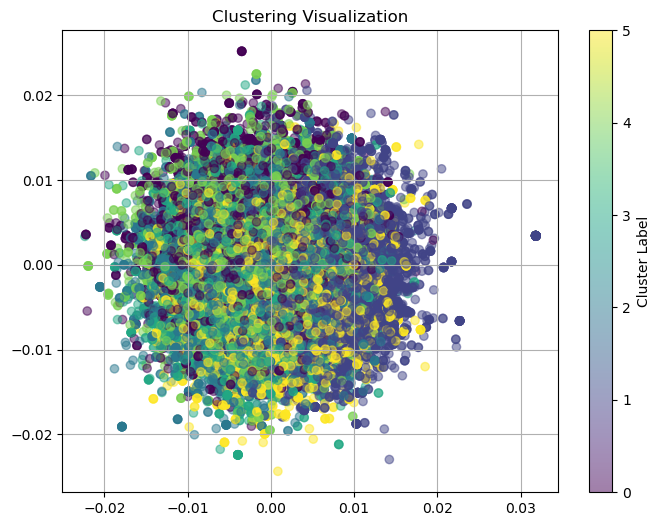

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('Clustering Visualization')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [26]:
from collections import Counter
cluster_counts = Counter(cluster_labels)
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} items")

Cluster 5: 11538 items
Cluster 0: 11320 items
Cluster 1: 11055 items
Cluster 3: 11244 items
Cluster 4: 11607 items
Cluster 2: 11680 items


* Now, we make a  k = 39 cluster, because all the sections/divisions of Roget's data are 39 in total. We will also print the corresponding clustering visualization. 

In [27]:
k = 39

kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_

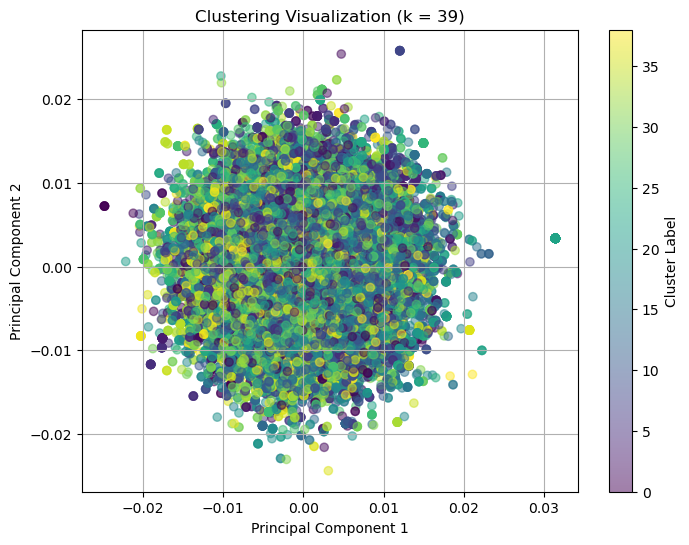

In [28]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('Clustering Visualization (k = 39)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [29]:
cluster_counts = Counter(cluster_labels)
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} items")

Cluster 12: 1749 items
Cluster 20: 1727 items
Cluster 1: 1809 items
Cluster 34: 1816 items
Cluster 33: 1811 items
Cluster 16: 1728 items
Cluster 13: 1874 items
Cluster 37: 1921 items
Cluster 14: 1758 items
Cluster 25: 1710 items
Cluster 35: 1853 items
Cluster 17: 1783 items
Cluster 18: 1607 items
Cluster 23: 1838 items
Cluster 21: 1744 items
Cluster 29: 1789 items
Cluster 4: 1711 items
Cluster 10: 1739 items
Cluster 9: 1929 items
Cluster 28: 1678 items
Cluster 38: 1680 items
Cluster 24: 1779 items
Cluster 7: 1838 items
Cluster 27: 1862 items
Cluster 5: 1860 items
Cluster 0: 1645 items
Cluster 26: 1754 items
Cluster 3: 1671 items
Cluster 36: 1672 items
Cluster 32: 1785 items
Cluster 19: 1710 items
Cluster 11: 1894 items
Cluster 22: 1385 items
Cluster 2: 1677 items
Cluster 15: 1654 items
Cluster 31: 1742 items
Cluster 6: 1703 items
Cluster 30: 1770 items
Cluster 8: 1789 items


* We observe that in both cases, depending on the centers identified by the cluster model, we have remarkable uniformity and homogeneity both in the numbers and in the diagrams. I believe that this uniformity is due to the semantic correlation of the words, and it is logical for them to be shaped this way.